In [1]:
import math
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 添加绘图功能
def plot_data(result, result_error, name, show=True):
    for i in range(len(result)):
        plt.scatter(result[i][:, 0], result[i][:, 1])
    if result_error is not None and len(result_error) != 0:
        plt.scatter(result_error[:, 0], result_error[:, 1])
    plt.title(f"{name} data")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    if show:
        plt.show()
        plt.close()

# 添加绘图功能
def plot_data_line(result, result_error, name, calculate_function, judge_max=True):
    plot_data(result, result_error, name, show=False)
    index_array = [[0, 1, 2], [0, 2, 1], [1, 2, 0]]
    result = []
    x = np.arange(-4, 12, 0.01)
    y = np.arange(-6, 10, 0.01)
    x, y = np.meshgrid(x, y)
    for i in range(x.shape[0]):
        result.append([])
        for j in range(x.shape[1]):
            temp_1 = calculate_function([x[i][j], y[i][j]], 0)
            temp_2 = calculate_function([x[i][j], y[i][j]], 1)
            temp_3 = calculate_function([x[i][j], y[i][j]], 2)
            result[i].append([temp_1, temp_2, temp_3])

    for item in index_array:
        z = np.zeros(x.shape)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                temp_1 = result[i][j][item[0]]
                temp_2 = result[i][j][item[1]]
                temp_3 = result[i][j][item[2]]
                z[i][j] = temp_1 - temp_2

                if judge_max:
                    if temp_3 > temp_1 and temp_3 > temp_2 and z[i][j] < 10e-6:
                        z[i][j] += 100
                else:
                    if temp_3 < temp_1 and temp_3 < temp_2 and z[i][j] < 10e-6:
                        z[i][j] += 100

                # z[i][j] = result[i][j][item[0]] - result[i][j][item[1]] + (
                #     1000 if result[i][j][item[2]] >= result[i][j][item[0]] and result[i][j][
                #         item[2]] >= result[i][j][item[1]] else 0)
        plt.contour(x, y, z, 0)
    plt.show()
    plt.close()

# 第一问
生成两个各包含$N = 1000$ 个二维样本的数据集 $X_1$ 和 $X_2$。数据集中的样本
来自于三个正态分布，分布的均值矢量分别为 $m_1 = [1,1]^T$、$m_2 = [4,4]^T$ 和 $m_3 = [8,1]^T$，分布的协方差矩阵为 $\Sigma_1 = \Sigma_2 = \Sigma_3 = 2I$，其中 $I$ 是 2 × 2 维的单位矩阵。在
生成数据集 $X_1$ 时，样本来自三个分布模型的先验概率相同，而在生成数据集 $X_2$ 时，
先验概率分别为 $p(\omega_1) = 0.6$、$p(\omega_2) = 0.3$ 和 $p(\omega_3) = 0.1$。分别画出所生成两个数
据集中样本的散布图。

In [3]:
m1 = np.array([1, 1])
m2 = np.array([4, 4])
m3 = np.array([8, 1])
COV = np.matrix([[2, 0],
                 [0, 2]])


# 根据均值矢量以及协方差使用正态分布生成数据集函数
def generate_value(means, count):
    return np.random.multivariate_normal(means, COV, count)


default_mean = [m1, m2, m3]
default_N = 1000
# X1的先验概率
X1_pre_probabilities = [0.333, 0.333, 0.334]
# X2的先验概率
X2_pre_probabilities = [0.6, 0.3, 0.1]


# 根据概率生成
def generate_by_p(p):
    data_list = []
    target_list = []
    for i in range(len(default_mean)):
        size = math.floor(default_N * p[i])
        data_list.append(generate_value(default_mean[i], size))
        target_list.append([i + 1] * size)
    return data_list, target_list

## 生成$X_1$ 和 $X_2$

In [4]:
temp_X1, temp_y1 = generate_by_p(X1_pre_probabilities)
temp_X2, temp_y2 = generate_by_p(X2_pre_probabilities)
X1 = np.concatenate(temp_X1, axis=0)
X2 = np.concatenate(temp_X2, axis=0)
y1 = [i for j in temp_y1 for i in j]
y2 = [i for j in temp_y2 for i in j]

## 绘制$X_1$图像

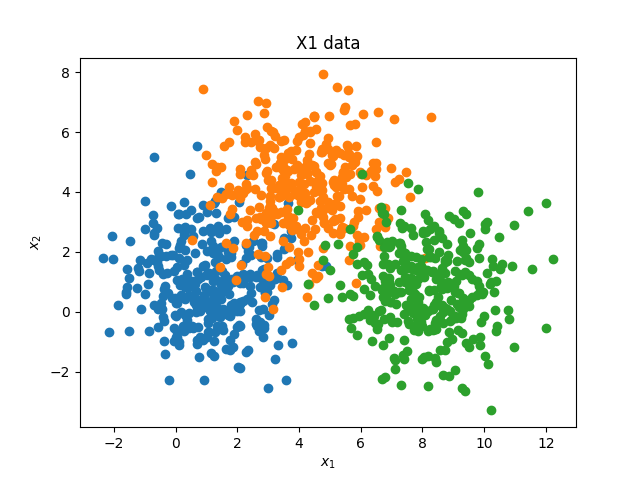

In [5]:
plot_data(temp_X1, None, "X1")

## 绘制$X_2$图像

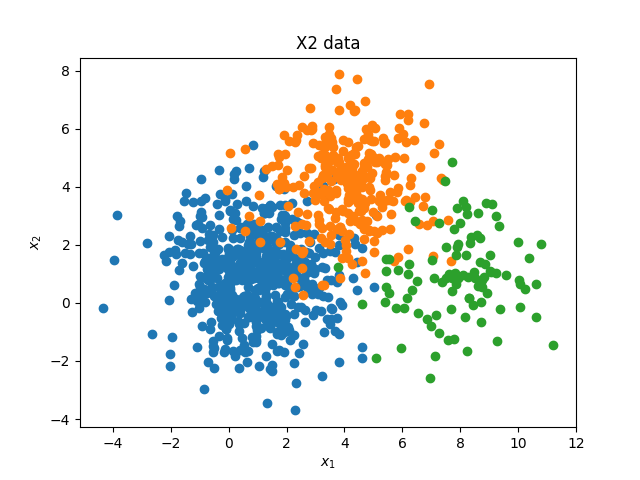

In [6]:
plot_data(temp_X2, None, "X2")

# 第二问
在两个数据集上分别应用“似然率决策规则”、“贝叶斯风险决策规则”（其中
$C_{12} = 2$, $C_{13} = 3$, $C_{23} = 2.5$, $C_{11} = C_{22} = C_{33} = 0$, $C_{21} = C_{31} = C_{32} = 1$）、“最小欧几里得距离分类器”进行样本分类实验，给出实验过程设计（包括源代码）和实验结果。
# 第三问
对每个数据集给出应用上述每种分类规则的分类决策界面和分类错误率，分析实验结果并给出结论。

## 决策规则:
在每个样本x处选择**最大化**或**最小化**某个函数$g_i(x)$的类标签$\omega_i$

$$
\text{decide } x \in \omega_i \text{ if } g_i(x) > g_j(x) \forall j \neq i
$$

### 似然率决策规则
多元正态分布的概率密度函数如下
$$
f(X) =  \frac{1}{\sqrt{(2\pi)^k |\Sigma|}} e^{-\frac{1}{2} (X - \mu)^T \Sigma^{-1} (X - \mu)}
$$
结合题目中变量可将$f(X)$转变为概率$P(X)$
$$
P(X|\omega_i) = \frac{1}{\sqrt{(2\pi)^k |\Sigma|}} e^{-\frac{1}{2} (X - m_i)^T \Sigma_i^{-1} (X - m_i)}
$$
因$\Sigma$为非奇异矩阵，且$k = r(\Sigma) = 2$ 则概率函数为:
$$
P(X|\omega_i) = \frac{1}{2\pi \sqrt{|\Sigma|}} e^{-\frac{1}{2} (X - m_i)^T \Sigma_i^{-1} (X - m_i)}
$$
结合似然决策规则
$$
\text{decide } x \in \omega_i \text{ if } \Lambda(x) = \frac{P(X|\omega_i)}{P(X|\omega_j)} > \frac{P(\omega_j)}{P(\omega_i)}
$$

In [7]:
def calculate_likelihood_probability(cov, x, m):
    temp = 1 / (2 * np.pi * np.sqrt(np.linalg.det(cov)))
    exp_param = np.matmul(np.matmul((x - m),  # (X - m)^T
                                    np.linalg.inv(cov)  # 协方差矩阵的逆
                                    ), (x - m).T  # (X - m)
                          )

    temp *= np.exp(-1 / 2 * exp_param)
    return temp


def calculate_likelihood_predict(cov, x, m_all, p_all):
    result = []
    for i in range(len(m_all)):
        result.append(calculate_likelihood_probability(cov, x, m_all[i]))
    for i in range(len(result)):
        can_use = True
        for j in range(len(result)):
            if i == j:
                continue

            if result[i] / result[j] < p_all[j] / p_all[i]:
                can_use = False
                break
        if can_use:
            return i + 1


def predict_likelihood(X, y, cov, m_all, p_all):
    size = X.shape[0]
    error_count = 0
    result_temp = []
    for _ in range(len(m_all)):
        result_temp.append([])
    result_error_temp = []
    for i in range(size):
        predict = calculate_likelihood_predict(cov, X[i], m_all, p_all)
        if predict != y[i]:
            error_count += 1
            result_error_temp.append([X[i][0], X[i][1]])
        else:
            result_temp[predict - 1].append([X[i][0], X[i][1]])
    result = []
    for item in result_temp:
        result.append(np.array(item))

    result_error = np.array(result_error_temp)
    return result, result_error

In [8]:
result_X1_likelihood, result_error_X1_likelihood = predict_likelihood(X1, y1, COV, default_mean, X1_pre_probabilities)
result_X2_likelihood, result_error_X2_likelihood = predict_likelihood(X2, y2, COV, default_mean, X2_pre_probabilities)

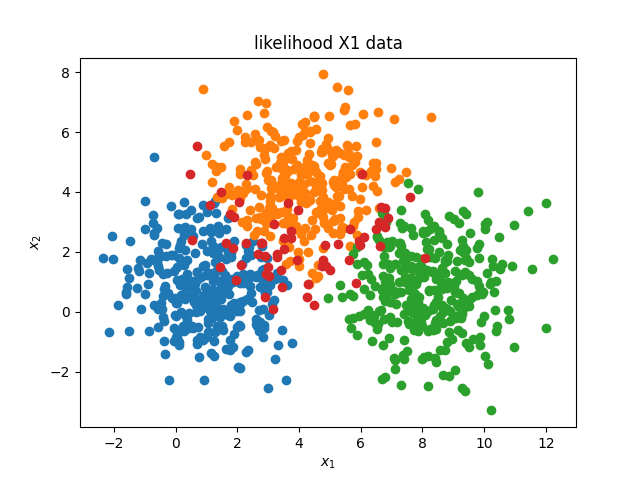

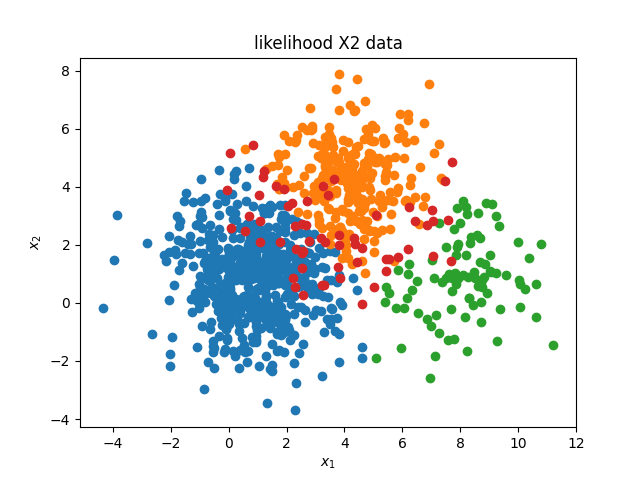

In [9]:
plot_data(result_X1_likelihood, result_error_X1_likelihood, 'likelihood X1')
plot_data(result_X2_likelihood, result_error_X2_likelihood, 'likelihood X2')

#### 计算决策界面
因决策规则为
$\frac{P(X|\omega_i)}{P(X|\omega_j)} > \frac{P(\omega_j)}{P(\omega_i)}$
即我们可以将其整理
$$
P(X|\omega_i)P(\omega_i) > P(X|\omega_j)P(\omega_j)\\
P(X|\omega_i)P(\omega_i) - P(X|\omega_j)P(\omega_j) > 0
$$
即为我们希望的界面分割线等式
$$
P(X|\omega_1)P(\omega_1) - P(X|\omega_2)P(\omega_2) = 0 \\
P(X|\omega_1)P(\omega_1) - P(X|\omega_3)P(\omega_3) = 0 \\
P(X|\omega_2)P(\omega_2) - P(X|\omega_3)P(\omega_3) = 0 \\
$$

In [10]:
def plot_likelihood_line(result, result_error, name, cov, m_all, p_all):
    plot_data_line(result, result_error, name, lambda x, i: calculate_likelihood_probability(cov, x, m_all[i]) * p_all[i])

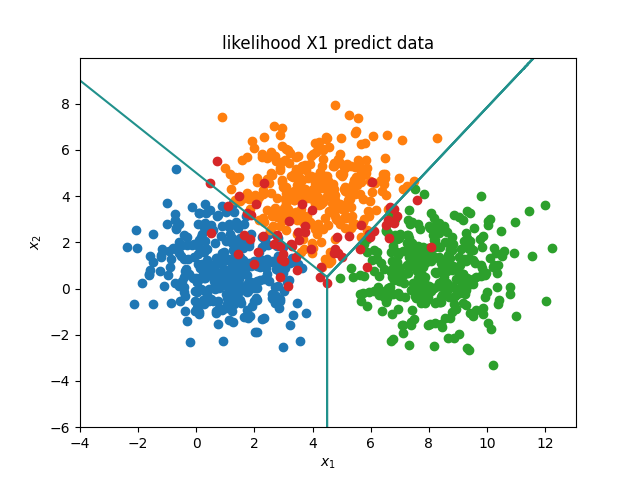

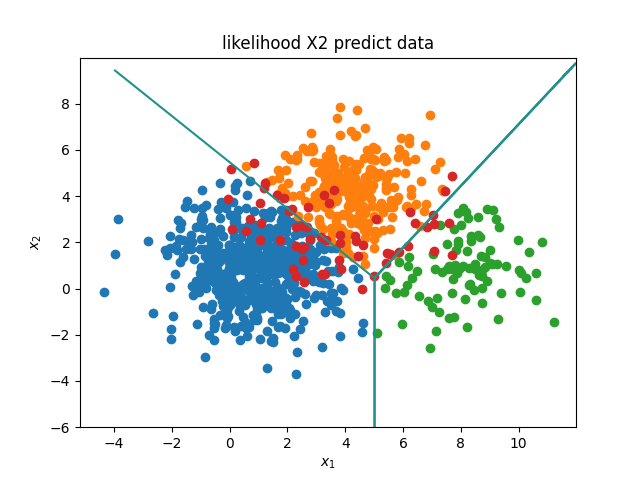

似然率决策规则的分类错误率X1为0.062
似然率决策规则的分类错误率X2为0.061


In [11]:
plot_likelihood_line(result_X1_likelihood, result_error_X1_likelihood, 'likelihood X1 predict', COV, default_mean, X1_pre_probabilities)
plot_likelihood_line(result_X2_likelihood, result_error_X2_likelihood, 'likelihood X2 predict', COV, default_mean, X2_pre_probabilities)
print(f"似然率决策规则的分类错误率X1为{len(result_error_X1_likelihood) / default_N}")
print(f"似然率决策规则的分类错误率X2为{len(result_error_X2_likelihood) / default_N}")

### 贝叶斯风险决策规则
其风险表达式为:
$$
    g_i(x) = \Re(\alpha_i|x) = \sum_{j = 1}^{C} C_{ij} P(\omega_j|x)
$$
其后验概率表达式为
$$
    P(\omega_i|x) = \frac{1}{2\pi\sqrt{|\Sigma_i|}}e^{-\frac{1}{2}(x-m_i)^T\Sigma_i^{-1}(x-m_i)}\frac{P(m_i)}{p(x)}
$$
其中， $C_{12} = 2$, $C_{13} = 3$, $C_{23} = 2.5$, $C_{11} = C_{22} = C_{33} = 0$, $C_{21} = C_{31} = C_{32} = 1$
因这里采用的是计算最小化贝叶斯风险的原则，所以其判别式会有如下改动
$$
\text{decide } x \in \omega_i \text{ if } g_i(x) < g_j(x) \forall j \neq i
$$
即选取所有可能条件中$g_i(x)$最小的那种

In [12]:
C = [[0, 2, 3],
     [1, 0, 2.5],
     [1, 1, 0]]

定义计算贝叶斯函数

In [13]:
# 计算贝叶斯的后验概率
def calculate_bayes_probability(cov, x, m, p):
    temp = 1 / (2 * np.pi * np.sqrt(np.linalg.det(cov)))
    exp_param = np.matmul(np.matmul((x - m), np.linalg.inv(cov)), (x - m).T)

    temp *= np.exp(-1 / 2 * exp_param)
    temp *= p / (1 / 1000)
    return temp


# 计算贝叶斯风险
def calculate_bayes_g_i_function(cov, x, m_all, p_all, i):
    temp = 0
    for j in range(len(m_all)):
        temp += C[i][j] * calculate_bayes_probability(cov, x, m_all[j], p_all[j])
    return temp


# 计算贝叶斯预测
def calculate_bayes_predict(x, cov, m_all, p_all):
    result = None
    result_index = 0
    for i in range(len(m_all)):
        temp = calculate_bayes_g_i_function(cov, x, m_all, p_all, i)
        # 因为这里采用的是贝叶斯风险计算，因此需要选择风险最小原则的
        if result is None or result > temp:
            result_index = i
            result = temp
    return result_index + 1


# 计算给定数据集预测正确性
def predict_bayes(X, y, cov, m_all, p_all):
    size = X.shape[0]
    error_count = 0
    result_temp = []
    for _ in range(len(m_all)):
        result_temp.append([])
    result_error_temp = []
    for i in range(size):
        predict = calculate_bayes_predict(X[i], cov, m_all, p_all)
        if predict != y[i]:
            error_count += 1
            result_error_temp.append([X[i][0], X[i][1]])
        else:
            result_temp[predict - 1].append([X[i][0], X[i][1]])
    result = []
    for item in result_temp:
        result.append(np.array(item))

    result_error = np.array(result_error_temp)
    return result, result_error

计算贝叶斯风险决策预估

In [14]:
result_X1_bayes, result_error_X1_bayes = predict_bayes(X1, y1, COV, default_mean, X1_pre_probabilities)
result_X2_bayes, result_error_X2_bayes = predict_bayes(X2, y2, COV, default_mean, X2_pre_probabilities)

对新分类重新标注错误

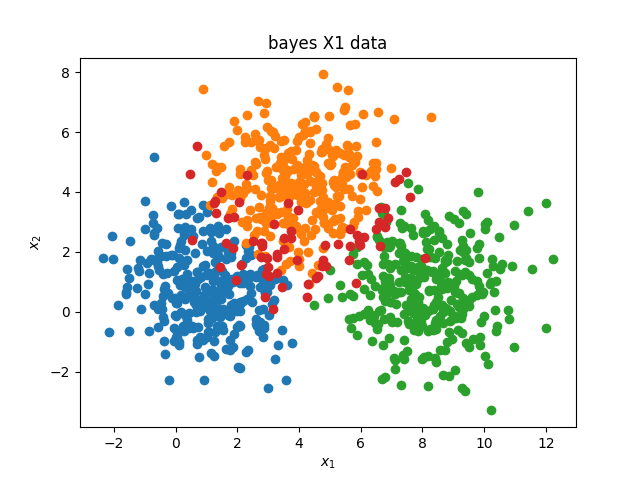

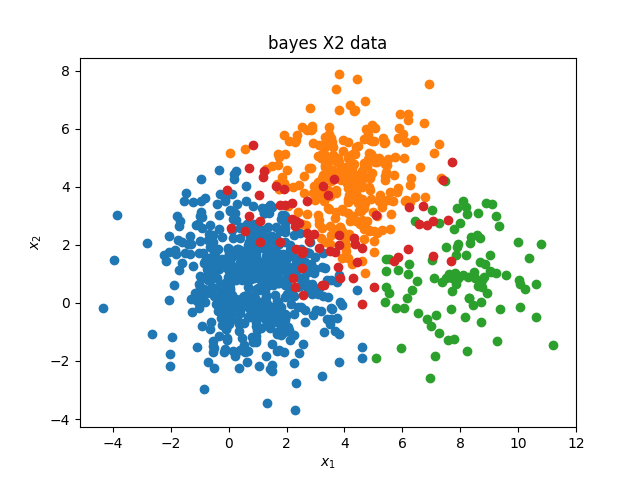

最小欧几里得距离分类器的分类错误率X1为0.07
最小欧几里得距离分类器的分类错误率X2为0.065


In [15]:
plot_data(result_X1_bayes, result_error_X1_bayes, 'bayes X1')
plot_data(result_X2_bayes, result_error_X2_bayes, 'bayes X2')
print(f"最小欧几里得距离分类器的分类错误率X1为{len(result_error_X1_bayes) / default_N}")
print(f"最小欧几里得距离分类器的分类错误率X2为{len(result_error_X2_bayes) / default_N}")

#### 计算分类边界和错误概率
这里理论上是有3条边界即
$$
    g_1(x)=g_2(x)\\
    g_1(x)=g_3(x)\\
    g_2(x)=g_3(x)
$$

In [16]:
# 定义绘制分界线函数
def plot_bayes_line(result, result_error, name, cov, m_all, p_all):
    plot_data_line(result, result_error, name, lambda x, i: calculate_bayes_g_i_function(cov, x, m_all, p_all, i), False)

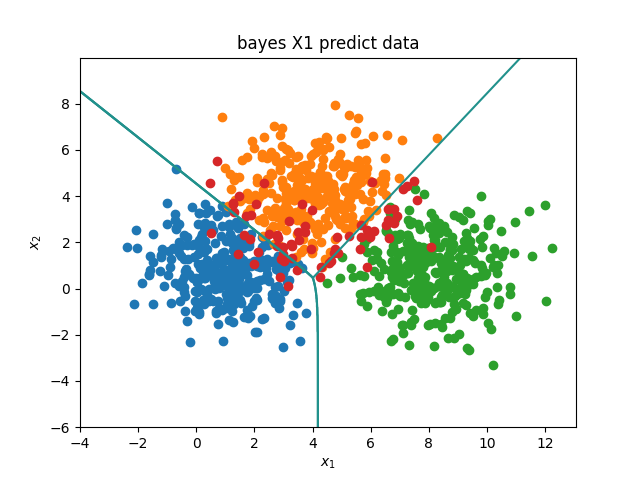

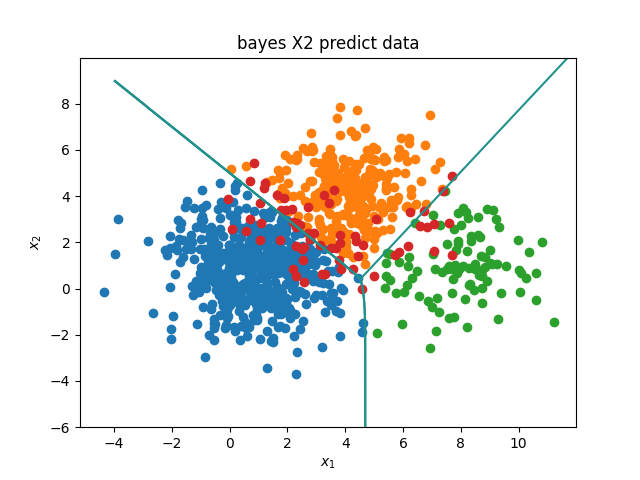

贝叶斯风险决策规则的分类错误率X1为0.07
贝叶斯风险决策规则的分类错误率X2为0.065


In [17]:
# 注: 因上式未经过numpy优化，因此计算速度会偏慢
plot_bayes_line(result_X1_bayes, result_error_X1_bayes, 'bayes X1 predict', COV, default_mean, X1_pre_probabilities)
plot_bayes_line(result_X2_bayes, result_error_X2_bayes, 'bayes X2 predict', COV, default_mean, X2_pre_probabilities)
print(f"贝叶斯风险决策规则的分类错误率X1为{len(result_error_X1_bayes) / default_N}")
print(f"贝叶斯风险决策规则的分类错误率X2为{len(result_error_X2_bayes) / default_N}")

#### 欧几里得距离分类器
其表达式为:
$$
g_i(x) = - \frac{1}{2}(x-m_i)^T(x-m_i)
$$

In [18]:
def min_euclid_distance(x, m):
    temp = x - m
    return - (1 / 2) * np.dot(temp, temp)


# 欧几里得距离分类器对所有可能种类做出判定，并取结合决策器给出最大可能预估
def calculate_euclid(x, m_all):
    temp_distance = None
    temp_index = 0
    for i in range(len(m_all)):
        current = min_euclid_distance(x, m_all[i])
        if temp_distance is None or temp_distance < current:
            temp_index = i
            temp_distance = current
    return temp_index + 1


def predict_euclid(X, y, m_all):
    size = X.shape[0]
    error_count = 0
    result_temp = []
    for _ in range(len(m_all)):
        result_temp.append([])
    result_error_temp = []
    for i in range(size):
        predict = calculate_euclid(X[i], m_all)
        if predict != y[i]:
            error_count += 1
            result_error_temp.append([X[i][0], X[i][1]])
        else:
            result_temp[predict - 1].append([X[i][0], X[i][1]])
    result = []
    for item in result_temp:
        result.append(np.array(item))

    result_error = np.array(result_error_temp)
    return result, result_error


result_X1_euclid, result_error_X1_euclid = predict_euclid(X1, y1, default_mean)
result_X2_euclid, result_error_X2_euclid = predict_euclid(X2, y2, default_mean)

##### 对新分类数据画图并标注错误

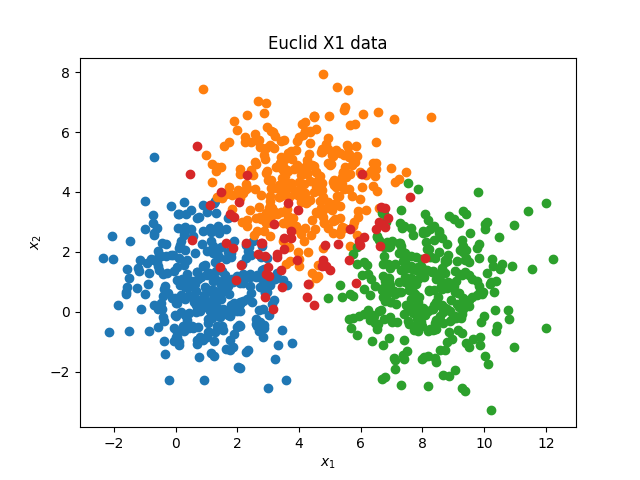

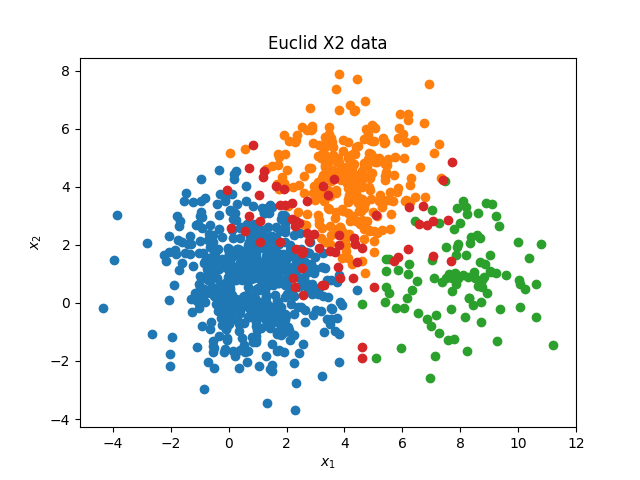

In [19]:
plot_data(result_X1_euclid, result_error_X1_euclid, 'Euclid X1')
plot_data(result_X2_euclid, result_error_X2_euclid, 'Euclid X2')

##### 计算分类边界
这里理论上是有3条边界
即
$$
    g_1(x)=g_2(x)\\
    g_1(x)=g_3(x)\\
    g_2(x)=g_3(x)
$$
详细式如下:
$$
    - \frac{1}{2}(x-m_1)^T(x-m_1) = - \frac{1}{2}(x-m_2)^T(x-m_2)\\
    - \frac{1}{2}(x-m_1)^T(x-m_1) = - \frac{1}{2}(x-m_3)^T(x-m_3)\\
    - \frac{1}{2}(x-m_2)^T(x-m_2) = - \frac{1}{2}(x-m_3)^T(x-m_3)\\
$$
将$m_1 = [1,1]^T$、$m_2 = [4,4]^T$ 和 $m_3 = [8,1]^T$代入展开
$$
    (x_1 - 1)^2 + (x_2 - 1)^2 = (x_1 - 4)^2 + (x_2 - 4)^2\\
    (x_1 - 1)^2 + (x_2 - 1)^2 = (x_1 - 8)^2 + (x_2 - 1)^2\\
    (x_1 - 4)^2 + (x_2 - 4)^2 = (x_1 - 8)^2 + (x_2 - 1)^2\\
$$

In [20]:
def euclid_first_line(x, y):
    return np.power(x - 1, 2) + np.power(y - 1, 2) - np.power(x - 4, 2) - np.power(y - 4, 2)


def euclid_second_line(x, y):
    return np.power(x - 1, 2) + np.power(y - 1, 2) - np.power(x - 8, 2) - np.power(y - 1, 2)


def euclid_third_line(x, y):
    return np.power(x - 4, 2) + np.power(y - 4, 2) - np.power(x - 8, 2) - np.power(y - 1, 2)


def plot_euclid_line(result, result_error, name, m_all):
    plot_data_line(result, result_error, name, lambda x, i: min_euclid_distance(x, m_all[i]))

##### 实验结果分析
由推导过程可以看出，最小欧几里得距离分类器仅与数据集中的正态分布均值有关，与其协方差矩阵无关（等价于协方差矩阵为单位矩阵）。

##### 对新分类数据画图并标注错误

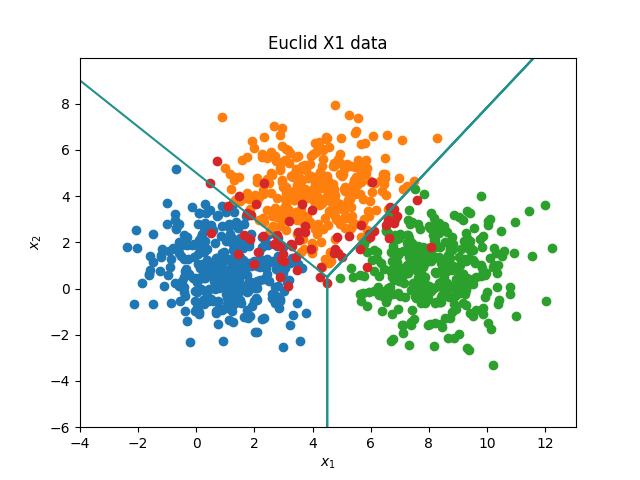

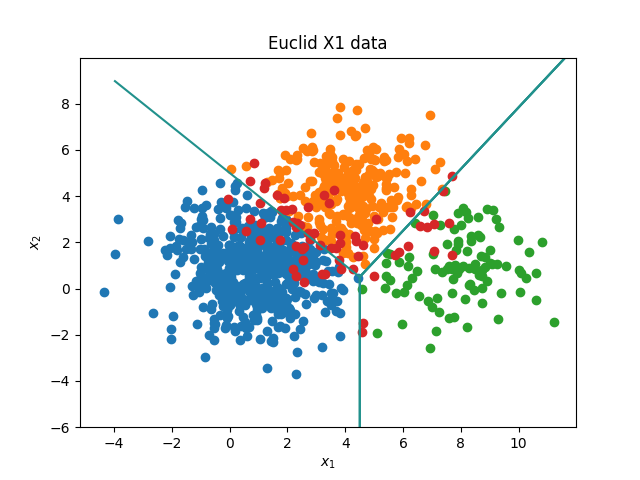

最小欧几里得距离分类器的分类错误率X1为0.062
最小欧几里得距离分类器的分类错误率X2为0.066


In [21]:
plot_euclid_line(result_X1_euclid, result_error_X1_euclid, 'Euclid X1', default_mean)
plot_euclid_line(result_X2_euclid, result_error_X2_euclid, 'Euclid X1', default_mean)

print(f"最小欧几里得距离分类器的分类错误率X1为{len(result_error_X1_euclid) / default_N}")
print(f"最小欧几里得距离分类器的分类错误率X2为{len(result_error_X2_euclid) / default_N}")